## Goal of this Notebook is to create Explore the datasets deeper in pytorch and creating the our own Custom Dataset


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

*What we're going to build. We'll use `torchvision.datasets` as well as our own custom `Dataset` class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.*

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Importing PyTorch and setting up device-agnostic code** | Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.  |
| **1. Get data** | We're going to be using our own **custom dataset** of pizza, steak and sushi images. |
| **2. Become one with the data (data preparation)** | At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have. |
| **3. Transforming data** |Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to *transform* our images so they're ready to be used with a model. | 
| **4. Loading data with `ImageFolder` (option 1)** | PyTorch has many in-built data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format. |
| **5. Loading image data with a custom `Dataset`** | What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of `torch.utils.data.Dataset`. |
| **6. Other forms of transforms (data augmentation)** | Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of `torchvision`'s in-built data augmentation functions. |
| **7. Model 0: TinyVGG without data augmentation** | By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model. |
| **8. Exploring loss curves** | Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**. |
| **9. Model 1: TinyVGG with data augmentation** | By now, we've tried a model *without*, how about we try one *with* data augmentation? |
| **10. Compare model results** | Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance. |
| **11. Making a prediction on a custom image** | Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image *outside* of our existing dataset. |

In [26]:
## importing the necessary libraries
import torch 
from torch import nn

In [27]:
# setting up our mps device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [66]:
from pathlib import Path
from torchvision import transforms

data_path = Path("pizza_steak_sushi")
train_path = Path(data_path) / "train"
test_path= Path(data_path) / "test"



In [67]:
train_path , test_path

(PosixPath('pizza_steak_sushi/train'), PosixPath('pizza_steak_sushi/test'))

### 1. transforming the data
* goal is to feed our images to the model and hope fully get the correct classification
* we can feed our images directly to the model first we need to trun them to tesnors -> {Dataset and Dataloders and transforms}


| **Problem space** | **Pre-built Datasets and Functions** |
| ----- | ----- |
| **Vision** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **Audio** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **Text** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **Recommendation system** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |


In [45]:
# we will compose the data transformation in here 
data_transform = transforms.Compose([
    transforms.Resize((64, 64)), # resizing the image to 224x224
    transforms.ToTensor(), # converting the image to tensor
    transforms.RandomHorizontalFlip(p=0.5) # randomly flipping the image horizontally
    ]
    )

In [46]:
test_image_paths = list(test_data.rglob("*.jpg"))  # or "*.png", etc.
test_image_paths[:5]  # Display the first 5 image paths

[PosixPath('pizza_steak_sushi/test/steak/413497.jpg'),
 PosixPath('pizza_steak_sushi/test/steak/2246332.jpg'),
 PosixPath('pizza_steak_sushi/test/steak/2475366.jpg'),
 PosixPath('pizza_steak_sushi/test/steak/1982192.jpg'),
 PosixPath('pizza_steak_sushi/test/steak/2353677.jpg')]

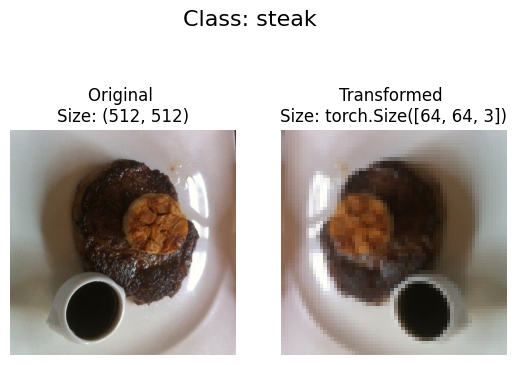

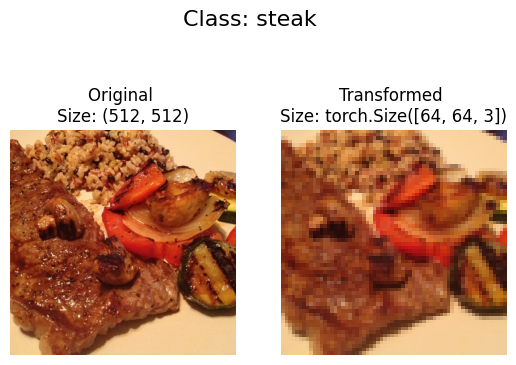

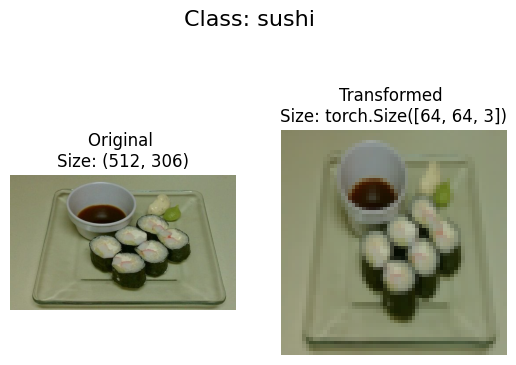

In [47]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(test_image_paths, 
                        transform=data_transform, 
                        n=3)

## loading our data using imagefoler prebulilt one
`torchvision.datasets.ImageFloder`

In [144]:
from torchvision import datasets 
train_data = datasets.ImageFolder(root=train_path,
                                      transform=data_transform
                                      )
test_data = datasets.ImageFolder(root=test_path, transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                RandomHorizontalFlip(p=0.5)
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                RandomHorizontalFlip(p=0.5)
            ))

`classes` and `class_to_idx`

In [49]:
classes = train_data.classes
class_to_idx = train_data.class_to_idx
classes, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [50]:
len(train_data), len(test_data)

(450, 150)

In [51]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Our images are now in the form of a tensor (with shape `[3, 64, 64]`) and the labels are in the form of an integer relating to a specific class (as referenced by the `class_to_idx` attribute).

How about we plot a single image tensor using `matplotlib`?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format `CHW` (color channels, height, width) but `matplotlib` prefers `HWC` (height, width, color channels).

Permuted image shape: torch.Size([64, 64, 3])
Permuted image datatype: torch.float32


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

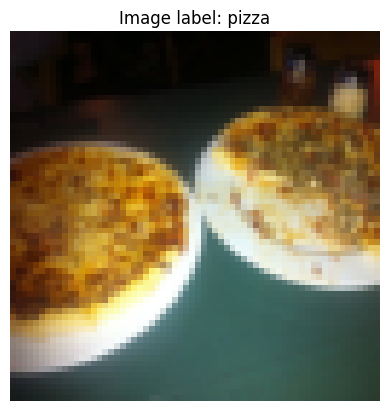

In [53]:
image_permute = img.permute(1, 2, 0)  # permute to [H, W, C] for visualization
print(f"Permuted image shape: {image_permute.shape}")
print(f"Permuted image datatype: {image_permute.dtype}")
import matplotlib.pyplot as plt
plt.imshow(image_permute)
plt.title(f"Image label: {classes[label]}")
plt.axis(False)

In [55]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data,
                                batch_size=1,
                                shuffle=True,
                                num_workers=1)
                          # num_workers=0 for MPS compatibility
test_dataloader = DataLoader(test_data,
                               batch_size=1,
                               shuffle=False,
                               num_workers=1)  # num_workers=0 for MPS compatibility

In [ ]:
train_dataloader, test_dataloader#now these are iterable objects, we can iterate through them

(<torch.utils.data.dataloader.DataLoader at 0x118172aa0>,
 <torch.utils.data.dataloader.DataLoader at 0x118173640>)

In [59]:
img , label = next(iter(train_dataloader))
print(f"Image tensor shape: {img.shape}")
print(f"Image label: {label}")
# plt.imshow(img[0].permute(1, 2, 0))  ÷

Image tensor shape: torch.Size([1, 3, 64, 64])
Image label: tensor([1])


### review of what we done

* took our dataset[root dataset] ->transformed -> loaded in image folder -> loaded it into iterable data loder

## Now we are going to build the custom dataset with all the fuctinolity 

In [63]:
import os
import pathlib
import torch

from PIL import Image 
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, List, Dict

***Funtionalities***
* classes , class_to_idx
* loadImage , length , getitem
* to achive get classes `os.scandir()` and for the rest we are going to write the code

In [64]:
def find_classes(directory:str)->Tuple[List[str], Dict[str, int]]:
    """
    Finds the class names in a directory structure.
    
    Args:
        directory (str): Path to the directory containing class subdirectories.
        
    Returns:
        Tuple containing a list of class names and a dictionary mapping class names to indices.
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [ ]:
find_classes(train_path) # we are returning the class names and their corresponding indices

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [106]:
from torch.utils.data import Dataset
from PIL import Image
import pathlib
from torchvision.datasets.folder import find_classes

class CustomImageDataset(Dataset):
    def __init__(self, trag_dir, transform):
        self.paths = list(pathlib.Path(trag_dir).rglob("*.jpg"))  # Store image paths
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(trag_dir)  # Auto-map classes from subfolders
    
    def load_image(self, index):
        image_path = self.paths[index]
        return Image.open(image_path).convert("RGB")  # Ensure consistent color mode
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        image_path = self.paths[index]
        class_name = image_path.parent.name  # Get folder name as class
        class_idx = self.class_to_idx[class_name]
        image = self.load_image(index)
        if self.transform:
            image = self.transform(image)
        return image, class_idx


In [107]:
train_data_custom = CustomImageDataset(trag_dir=train_path, transform=data_transform)
test_data_custom = CustomImageDataset(trag_dir=test_path, transform=data_transform)

In [108]:
train_data_custom , test_data_custom

(<__main__.CustomImageDataset at 0x14738b580>,
 <__main__.CustomImageDataset at 0x147388340>)

In [109]:
len(train_data_custom), len(test_data_custom)

(450, 150)

In [110]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [111]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [112]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [113]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

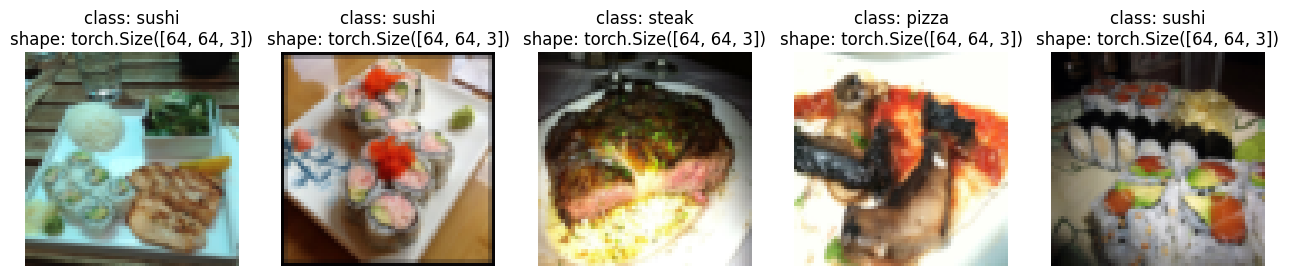

In [117]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=classes ,
                    )

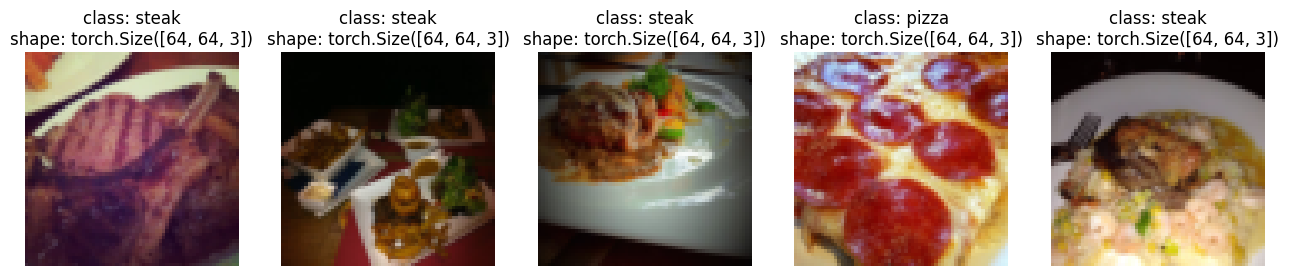

In [116]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data_custom, 
                      n=5, 
                      classes=classes ,
                      )

In [118]:
## loading our custom dataset
train_dataloader_custom = DataLoader(dataset=train_data_custom,batch_size=1, shuffle=True, num_workers=0)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=1, shuffle=False, num_workers=0)

In [119]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Model Creation

In [121]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [122]:
train_data_simple = datasets.ImageFolder(root=train_path, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_path, transform=simple_transform)

In [123]:
batch_size = 32
num_workers =os.cpu_count() 
train_dataloader_simple = DataLoader(train_data_simple, 
                                      batch_size=batch_size, 
                                      shuffle=True, 
                                      num_workers=num_workers)
test_dataloader_simple = DataLoader(test_data_simple,
                                     batch_size=batch_size,
                                     shuffle=False,
                                     num_workers=num_workers)

In [126]:
# For training data
print(f"Train batch size: {train_dataloader_simple.batch_size}")
print(f"Train dataset size: {len(train_dataloader_simple.dataset)}")

# For test data
print(f"Test batch size: {test_dataloader_simple.batch_size}")
print(f"Test dataset size: {len(test_dataloader_simple.dataset)}")


Train batch size: 32
Train dataset size: 450
Test batch size: 32
Test dataset size: 150


In [127]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [130]:
img_batch, label_batch = next(iter(train_dataloader_simple))
img_singe = img_batch[0].unsqueeze(dim=0)  # Add batch dimension
label_singe = label_batch[0]  
print(f"shape of the single image and label {img_singe.shape}, {label_singe.shape}")

shape of the single image and label torch.Size([1, 3, 64, 64]), torch.Size([])


* we are doing the inference testing of our model seeing its base capabilities 


In [135]:
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_singe.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_singe}")

Output logits:
tensor([[0.0594, 0.0576, 0.0372]], device='mps:0')

Output prediction probabilities:
tensor([[0.3360, 0.3354, 0.3286]], device='mps:0')

Output prediction label:
tensor([0], device='mps:0')

Actual label:
0


* installing the `torchinfo` to see the indepth sumary

In [136]:
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) 


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## now we got the jist of the model we can begin with the training of the mode
* training step
*  testing step
* loop to combine all of them

In [137]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [138]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [139]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

/Users/bhushanchowdary/Documents/GitHub/PyTorch_fundamentals/torch-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [140]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [01:22<05:29, 82.47s/it]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.3604 | test_loss: 1.0975 | test_acc: 0.3625


 40%|████      | 2/5 [02:42<04:02, 80.82s/it]

Epoch: 2 | train_loss: 1.1013 | train_acc: 0.3250 | test_loss: 1.1002 | test_acc: 0.3750


 60%|██████    | 3/5 [04:01<02:40, 80.32s/it]

Epoch: 3 | train_loss: 1.0987 | train_acc: 0.3354 | test_loss: 1.0960 | test_acc: 0.3625


 80%|████████  | 4/5 [05:21<01:19, 79.95s/it]

Epoch: 4 | train_loss: 1.0958 | train_acc: 0.3563 | test_loss: 1.0873 | test_acc: 0.5341


100%|██████████| 5/5 [06:40<00:00, 80.14s/it]

Epoch: 5 | train_loss: 1.0783 | train_acc: 0.5146 | test_loss: 1.0552 | test_acc: 0.4455
Total training time: 400.699 seconds


In [141]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [145]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_path, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_path, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [146]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x119126050>,
 <torch.utils.data.dataloader.DataLoader at 0x118173640>)

In [147]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [148]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [01:19<05:19, 79.93s/it]

Epoch: 1 | train_loss: 1.1059 | train_acc: 0.3083 | test_loss: 1.1053 | test_acc: 0.2875


 40%|████      | 2/5 [02:39<03:59, 79.69s/it]

Epoch: 2 | train_loss: 1.1008 | train_acc: 0.3521 | test_loss: 1.0994 | test_acc: 0.2938


 60%|██████    | 3/5 [03:58<02:39, 79.58s/it]

Epoch: 3 | train_loss: 1.0981 | train_acc: 0.3250 | test_loss: 1.0918 | test_acc: 0.3312


 80%|████████  | 4/5 [05:18<01:19, 79.60s/it]

Epoch: 4 | train_loss: 1.0888 | train_acc: 0.3833 | test_loss: 1.0788 | test_acc: 0.4295


100%|██████████| 5/5 [06:38<00:00, 79.61s/it]

Epoch: 5 | train_loss: 1.0742 | train_acc: 0.4146 | test_loss: 1.0769 | test_acc: 0.3375
Total training time: 398.060 seconds


## Main takeaways

* PyTorch has many in-built functions to deal with all kinds of data, from vision to text to audio to recommendation systems.
* If PyTorch's built-in data loading functions don't suit your requirements, you can write code to create your own custom datasets by subclassing `torch.utils.data.Dataset`.
* `torch.utils.data.DataLoader`'s in PyTorch help turn your `Dataset`'s into iterables that can be used when training and testing a model.
* A lot of machine learning is dealing with the balance between **overfitting** and **underfitting** (we discussed different methods for each above, so a good exercise would be to research more and writing code to try out the different techniques).
* Predicting on your own custom data with a trained model is possible, as long as you format the data into a similar format to what the model was trained on. Make sure you take care of the three big PyTorch and deep learning errors:
    1. **Wrong datatypes** - Your model expected `torch.float32` when your data is `torch.uint8`.
    2. **Wrong data shapes** - Your model expected `[batch_size, color_channels, height, width]` when your data is `[color_channels, height, width]`.
    3. **Wrong devices** - Your model is on the GPU but your data is on the CPU. 